# Re-Purposing a Pretrained Network



### Output
This notebook extracts a vector representation of a set of images using the GoogLeNet CNN pretrained on ImageNet.  It then builds a classifier, so that new images can be classified directly.


In [1]:
import theano
import theano.tensor as T

import lasagne

import numpy as np
import scipy

import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import time

/home/andrewsm/OpenSource/fossasia-2016_deep-learning/env/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


Functions for building the GoogLeNet model with Lasagne and preprocessing the images are defined in model.googlenet.

Build the model and select layers we need - the features are taken from the final network layer, before the softmax nonlinearity.

In [2]:
from model import googlenet

cnn_layers = googlenet.build_model()
cnn_input_var = cnn_layers['input'].input_var
cnn_feature_layer = cnn_layers['loss3/classifier']
cnn_output_layer = cnn_layers['prob']

get_cnn_features = theano.function([cnn_input_var], lasagne.layers.get_output(cnn_feature_layer))

Load the pretrained weights into the network :

In [3]:
params = pickle.load(open('./data/googlenet/blvc_googlenet.pkl'))
model_param_values = params['param values']
classes = params['synset words']
lasagne.layers.set_all_param_values(cnn_output_layer, model_param_values)

### Use the Network to create 'features' for the training images

Now go through the input images and feature-ize them according to the pretrained network.

NB: The pretraining was done on ImageNet - there wasn't anything specific to the recognition task we're doing here.

In [4]:
import os
image_dir='./images/cars'
image_files = [f for f in os.listdir(image_dir) if not f.startswith('.')]
image_files.sort()

DONE :   0.51 seconds each


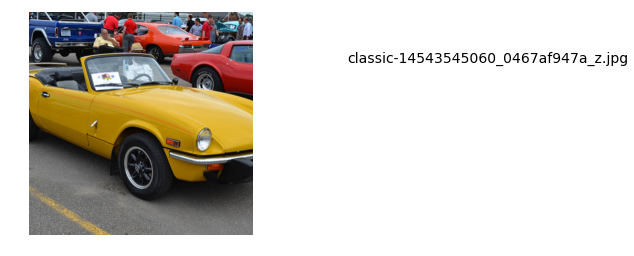

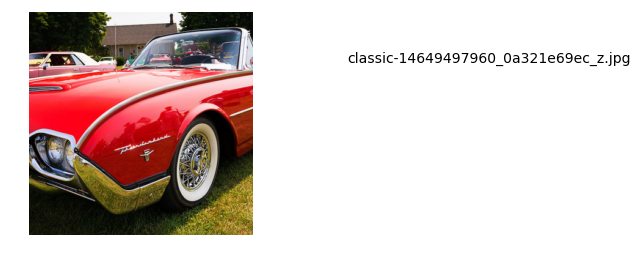

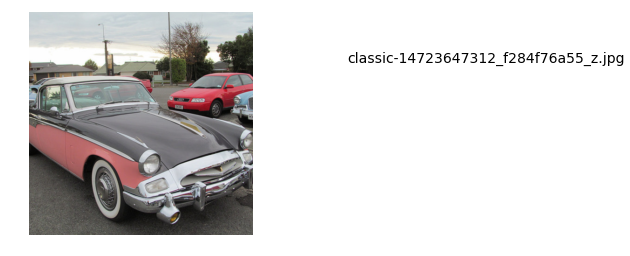

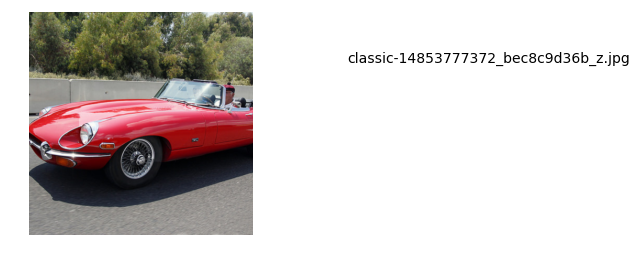

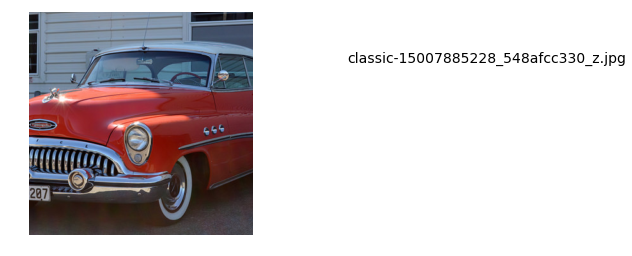

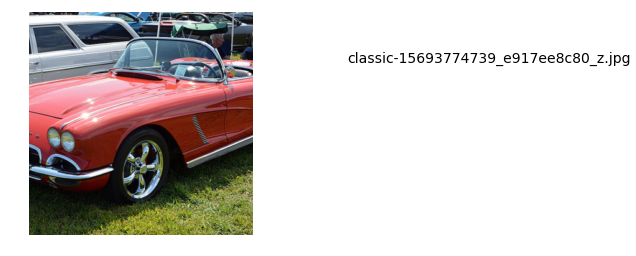

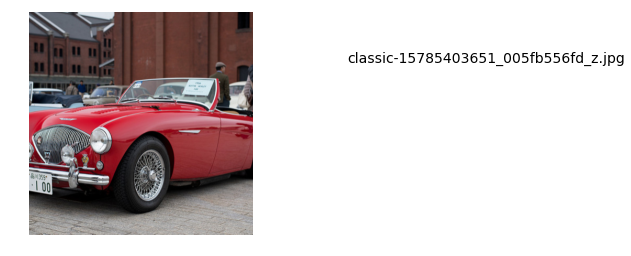

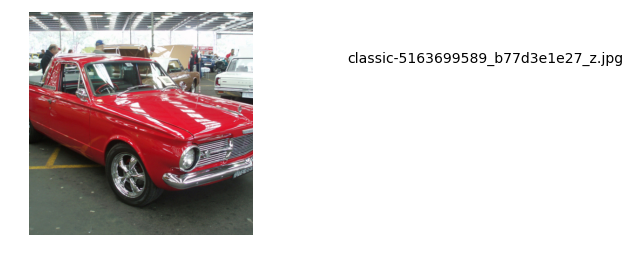

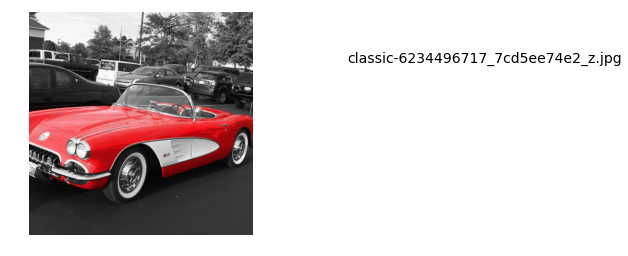

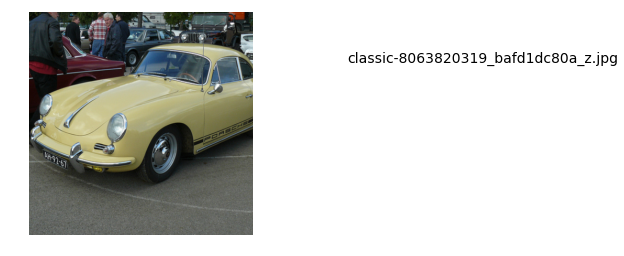

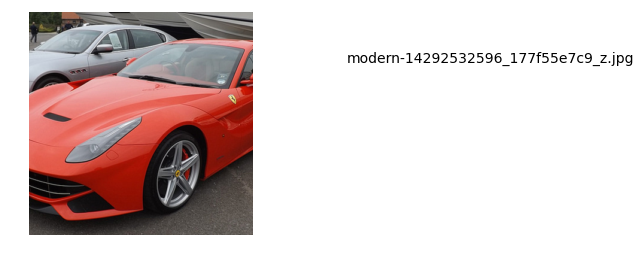

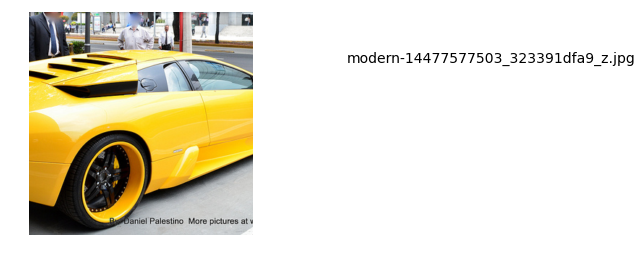

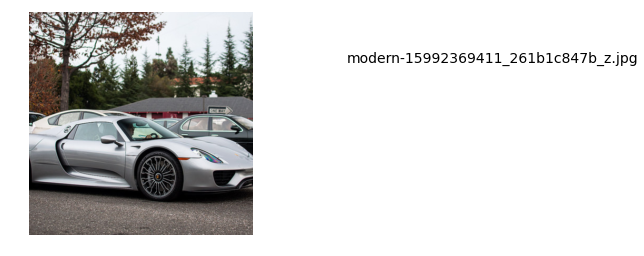

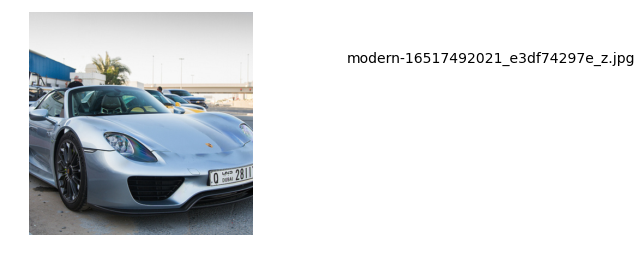

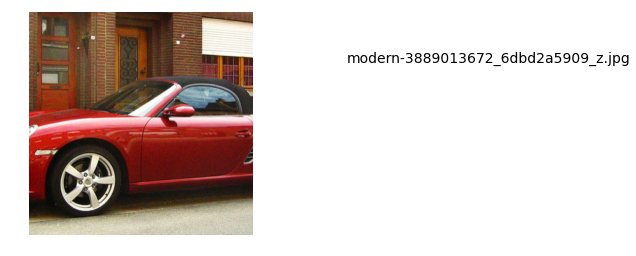

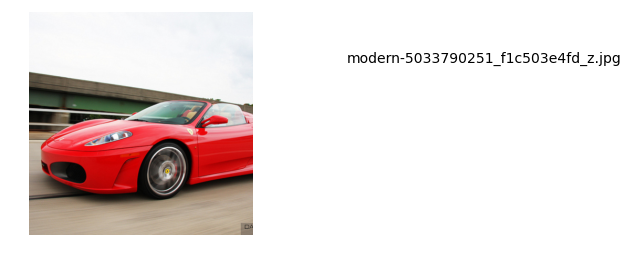

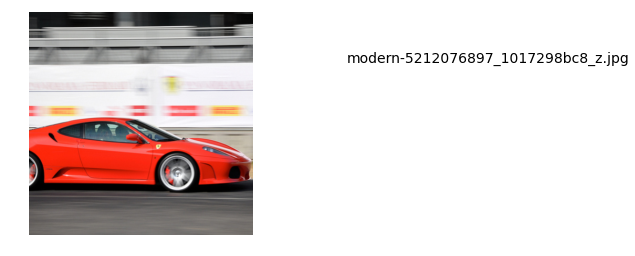

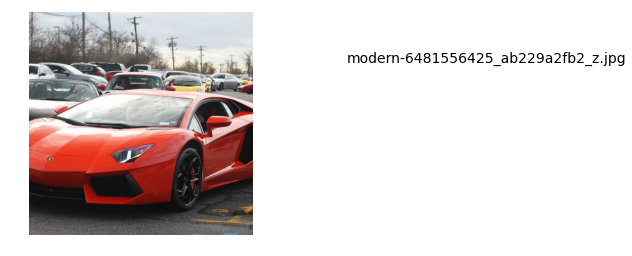

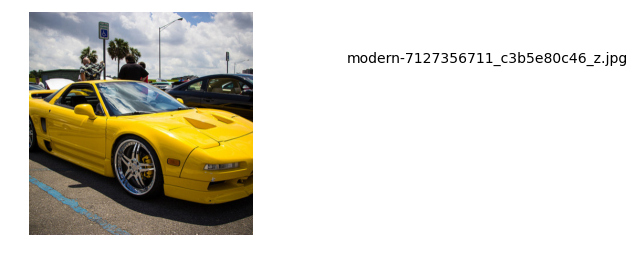

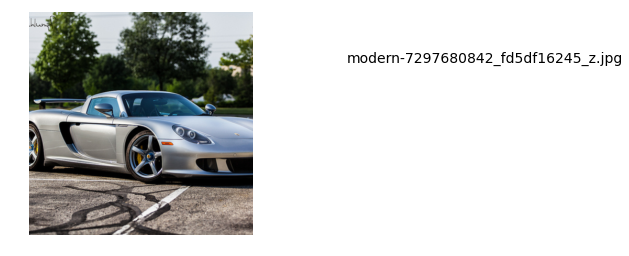

In [5]:
training_image_files = [f for f in image_files if f.startswith('classic-') or f.startswith('modern-')]
train = dict(f=[], features=[], target=[])

t0 = time.time()
for f in training_image_files:
    im = plt.imread('%s/%s' % (image_dir,f,))
    rawim, cnn_im = googlenet.prep_image(im)
        
    prob = get_cnn_features(cnn_im)

    train['f'].append(f)
    train['features'].append(prob[0])
    train['target'].append( 1 if f.startswith('modern-') else 0)
    
    if True:
        plt.figure()
        plt.imshow(rawim.astype('uint8'))
        plt.axis('off')

        plt.text(320, 50, '{}'.format(f), fontsize=14)
    
print("DONE : %6.2f seconds each" %(float(time.time() - t0)/len(training_image_files),))

###  Build an SVM model over the features

In [6]:
#train['features'][0]

In [7]:
from sklearn import svm
classifier = svm.LinearSVC()
classifier.fit(train['features'], train['target']) # learn from the data 

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

###  Use the SVM model to classify the test set

DONE :   0.51 seconds each


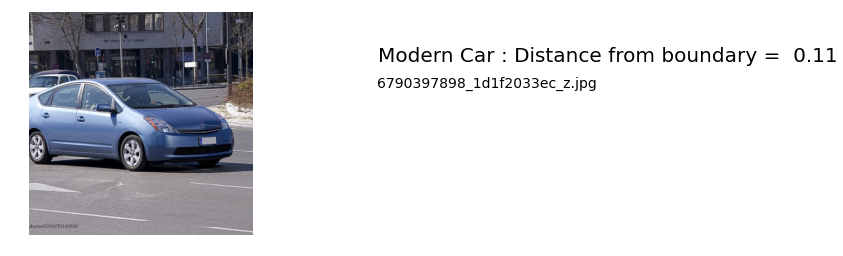

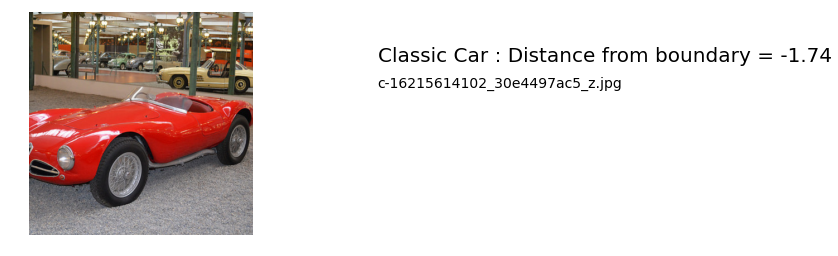

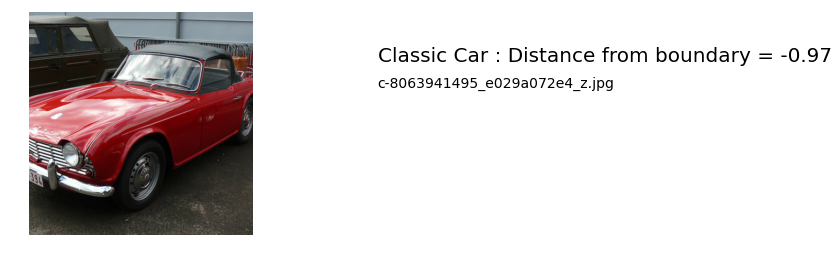

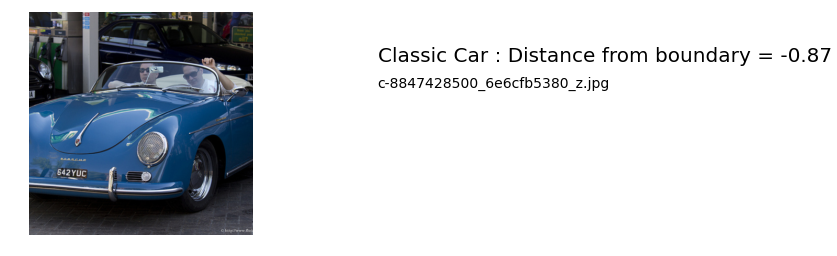

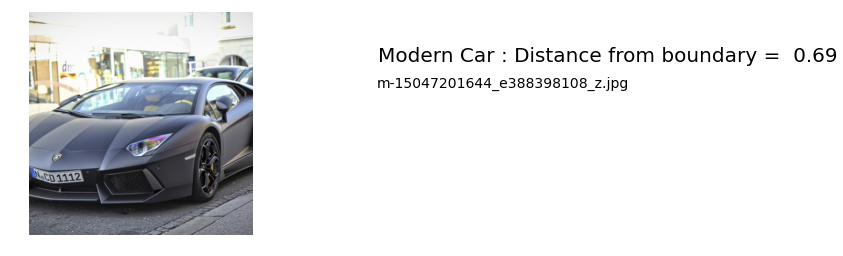

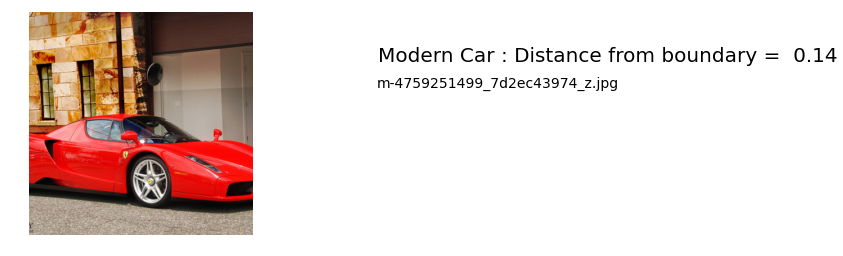

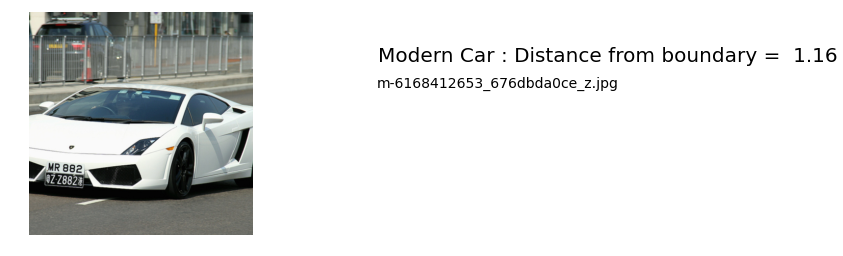

In [8]:
test_image_files = [f for f in image_files if not (f.startswith('classic-') or f.startswith('modern-'))]

t0 = time.time()
for f in test_image_files:
    im = plt.imread('%s/%s' % (image_dir,f,))
    rawim, cnn_im = googlenet.prep_image(im)
        
    prob = get_cnn_features(cnn_im)

    prediction_i = classifier.predict([ prob[0] ])
    decision     = classifier.decision_function([ prob[0] ])
                       
    plt.figure()
    plt.imshow(rawim.astype('uint8'))
    plt.axis('off')
                
    prediction = [ 'Classic Car', 'Modern Car'][ prediction_i[0] ]
                       
    plt.text(350, 50, '{} : Distance from boundary = {:5.2f}'.format(prediction, decision[0]), fontsize=20)
    plt.text(350, 75, '{}'.format(f), fontsize=14)
    
print("DONE : %6.2f seconds each" %(float(time.time() - t0)/len(test_image_files),))

Did it work?

Idea : Try uploading your own images into ./images/cars  (any .jpg will do)